In [1]:
balance_names = []

In [2]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk
tf.random.set_seed(42)

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
reduction = 1

img_width = int(40/reduction)
img_height = int(600/reduction)

In [5]:
image_names = []
path = pathlib.Path(r'O:\eve_models\training_data\route_y')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [6]:
random.shuffle(image_names)

In [7]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox'][1:2]
image_data[list(image_data.keys())[0]]

[377]

In [8]:
def convert_to_baw(img, thresh=80):
    fn = lambda x: 255 if x > thresh else 0
    return img.convert('L').point(fn, mode='1')

In [9]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.7), int(len(image_names)*0.9)])

In [10]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        #img = convert_to_baw(img)
        img = img.crop((120, 0, 160, 600))
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    img = img.crop((120, 0, 160, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    img = img.crop((120, 0, 160, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    test_x.append(np.array(img))

100%|███████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 259.23it/s]


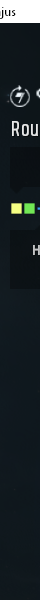

In [11]:
Image.fromarray(train_x[0])

In [12]:
train_x[0].shape

(600, 40, 3)

In [13]:
np.array([[1]*9]*2).shape

(2, 9)

In [14]:
len(train_x)

1218

In [15]:
train_x[0].shape

(600, 40, 3)

In [16]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name][0])
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name][0])
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name][0])

100%|████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<?, ?it/s]


In [17]:
len(train_x)

1218

In [18]:
train_x[0].shape

(600, 40, 3)

In [19]:
len(train_y)

1218

In [20]:
train_y[0]

204

In [21]:
augmentations = 0
aug_range_y = [-60, 80]

#balance_names = []

train_alter_x = []
train_alter_y = []
train_alter_names = []
for i in tqdm(range(len(train_x))):
    true_aug = augmentations
    if train_names[i] in balance_names:
        true_aug = augmentations * (balance_names.count(train_names[i]))
        
    for a in range(true_aug):
        img = Image.fromarray(train_x[i])
        x_pixels = 0  
        y_pixels = random.randint(*aug_range_y)
        translated_img = img.transform(img.size, Image.AFFINE, (1, 0, x_pixels, 0, 1, y_pixels))
        train_alter_x.append(np.array(translated_img))

        train_alter_y.append(train_y[i] - y_pixels)
        train_alter_names.append(train_names[i])

train_x = train_x + train_alter_x
train_y = train_y + train_alter_y
train_names = np.array(list(train_names) + train_alter_names)

100%|█████████████████████████████████████████████████████████████████████████| 1218/1218 [00:00<00:00, 1215190.84it/s]


In [22]:
train_y[0]

204

In [23]:
train_y[-1]

296

In [24]:
len(train_x)

1218

In [25]:
train_x[0].shape

(600, 40, 3)

In [26]:
len(train_y)

1218

In [27]:
len(train_alter_y)

0

In [28]:
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

train_y = np.array(train_y) / np.array([1000])
val_y = np.array(val_y) / np.array([1000])
test_y = np.array(test_y) / np.array([1000])

In [29]:
train_y[0]

0.204

In [30]:
train_y[-1]

0.296

In [31]:
train_x[30].shape

(600, 40, 3)

<Axes: ylabel='Count'>

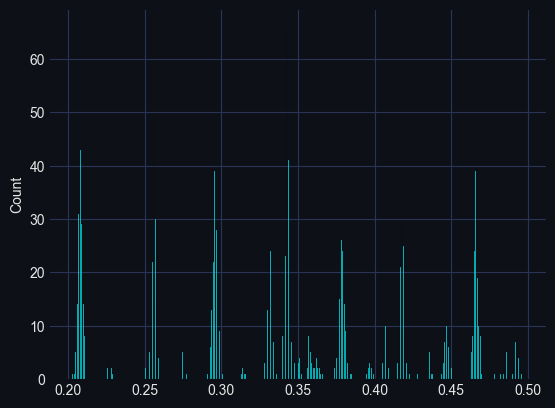

In [32]:
import seaborn as sns
sns.histplot(train_y, bins=600)

In [33]:
len(train_x)

1218

In [34]:
# measures of dispersion
min_ = np.amin(train_y)
max_ = np.amax(train_y)
range_ = np.ptp(train_y)
variance = np.var(train_y)
sd = np.std(train_y)
 
#print("Array =", train_y)
print("Measures of Dispersion")
print("Minimum =", min_)
print("Maximum =", max_)
print("Range =", range_)
print("Variance =", variance)
print("Standard Deviation =", sd)

Measures of Dispersion
Minimum = 0.203
Maximum = 0.497
Range = 0.294
Variance = 0.006661266816040725
Standard Deviation = 0.08161658419733532


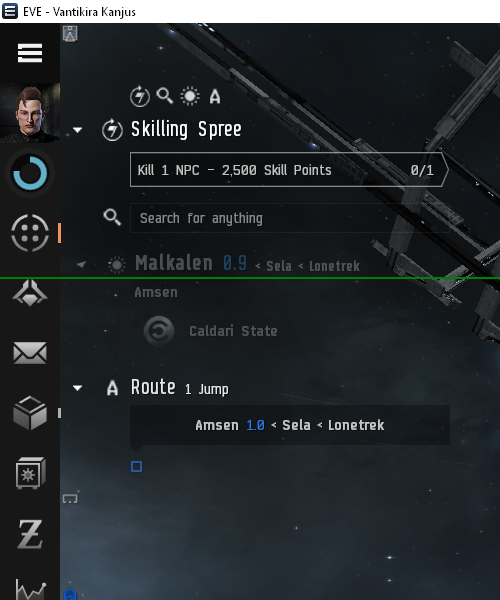

In [35]:
index = 20
img = Image.open(f"{path}\\{train_names[index]}")
truth = (train_y[index] * np.array([600])) # reduction
img1 = ImageDraw.Draw(img)  
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img

In [36]:
config_meta = {'image_resize': [20, 8],
     'class_location': 'O:\\eve_models\\training_data\\box_counter\\box_counter_classes.json',
     'model_location': 'O:\\eve_models\\training_data\\box_counter\\box_counter_model.h5',
     'class_names': ['1', '2'],
     'cm': [[ 70,   0],
            [  0, 115]]}
box_counter_model = tf.keras.models.load_model(config_meta['model_location'], compile=False)
config = json.load(open(config_meta['class_location']))
config

['1', '2']

In [47]:
box_counter_model.layers[0].input

<KerasTensor: shape=(None, 20, 8, 3) dtype=float32 (created by layer 'rescaling_input')>

In [44]:
source_model = tf.keras.Model(box_counter_model.layers[0].input, box_counter_model.layers[7].output)
for source_layer in source_model.layers:
    source_model.trainable = False

In [48]:
vgg = VGG16(weights="imagenet",
            include_top=False,
            #input_tensor=layers.Input(shape=(img_height, img_width, 3))
                    )

fine_tune = 1

if fine_tune > 0:
    for layer in vgg.layers[:-fine_tune]:
        layer.trainable = False
else:
    for layer in vgg.layers:
        layer.trainable = False

model = Sequential([
    #layers.Input(shape=(img_height, img_width,3)),
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width,3)),
    layers.Resizing(20, 8, interpolation='nearest'),
    source_model,
    layers.Flatten(),
    #layers.Dense(units=128, activation='relu'),
    #layers.Dense(units=64, activation='relu'),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=1, activation="sigmoid", name='bounding_box')  
])


epochs = 100
lr = 1e-3

callbacks = [
    ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.1, patience=5, min_lr=1e-10, verbose=1),
    #lr_finder,
    EarlyStopping(monitor='val_root_mean_squared_error', patience=20, restore_best_weights=False),
]

#model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.mae, metrics=['accuracy', 'mse', 'mae'])
model.compile(optimizer=Adam(lr), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.losses.MeanSquaredError()], loss_weights={"bounding_box": 1.0})

history = model.fit(
    x=tf.keras.applications.vgg16.preprocess_input(train_x),
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=512,
    shuffle=True,
    epochs=epochs,
    callbacks=callbacks
)



Epoch 1/100
3/3 [==============================] - 8s 192ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791 - mean_squared_error: 0.0319 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1778 - val_mean_squared_error: 0.0316 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 71ms/step - loss: 0.0294 - root_mean_squared_error: 0.1714 - mean_squared_error: 0.0288 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1715 - val_mean_squared_error: 0.0294 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 69ms/step - loss: 0.0275 - root_mean_squared_error: 0.1657 - mean_squared_error: 0.0271 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1671 - val_mean_squared_error: 0.0279 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 73ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615 - mean_squared_error: 0.0259 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1630 - val_mean_squared_error: 0.0266 - lr: 0.0010
Epoch 5/100
3/3 [==

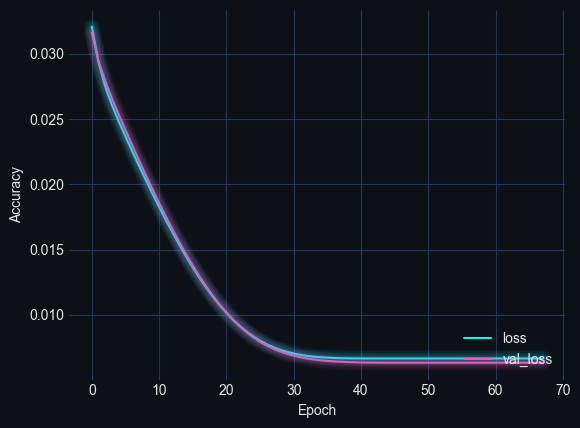

In [49]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
mplcyberpunk.make_lines_glow()

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

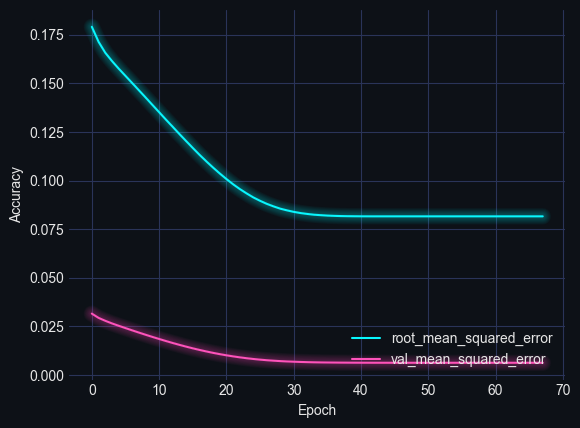

In [50]:
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
mplcyberpunk.make_lines_glow()

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

1/1 [==============================] - 0s 288ms/step
[340.66554904]
[418.]


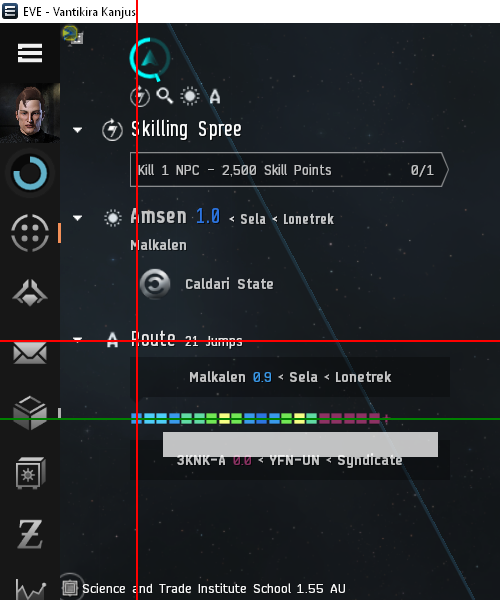

In [51]:
test_image_index = 2

prediction = model.predict(np.array([test_x[test_image_index]]))
result = ((prediction) * np.array([1000])) # reduction
result = result[0]
print(result)
truth = (test_y[test_image_index] * np.array([1000])) # reduction
print(truth)

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.open(f"{path}\\{test_names[test_image_index]}")
img1 = ImageDraw.Draw(img)  
#img1.ellipse((result[0]-10,result[1]-10,result[0]+10,result[1]+10), outline ="red", width=5)
#img1.ellipse((truth[0]-10,truth[1]-10,truth[0]+10,truth[1]+10), outline ="Green", width=5)
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img1.line([(0,result[0]),(500,result[0])], fill ="Red", width=2)
img1.line([(136,0),(136,600)], fill ="Red", width=2)


img

In [ ]:
model.save('test_location.h5')

In [ ]:
from tensorflow.keras import backend as K
predictions = model.predict(train_x)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
rmses = []
for i in tqdm(range(len(train_x))):
    
    rmse = root_mean_squared_error(train_y[i], predictions[i]).numpy()
    rmses.append(rmse)




test_image_index = np.argmax(rmses)
print(f"Worst RMSE:{rmses[test_image_index]}")

prediction = model.predict(np.array([train_x[test_image_index]]))
result = ((prediction) * np.array([1000])) # reduction
result = result[0]
print(result)
truth = (train_y[test_image_index] * np.array([1000])) # reduction
print(truth)

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.fromarray(train_x[test_image_index])
img1 = ImageDraw.Draw(img)  
#img1.ellipse((result[0]-10,result[1]-10,result[0]+10,result[1]+10), outline ="red", width=5)
#img1.ellipse((truth[0]-10,truth[1]-10,truth[0]+10,truth[1]+10), outline ="Green", width=5)
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img1.line([(0,result[0]),(500,result[0])], fill ="Red", width=2)
img1.line([(136,0),(136,600)], fill ="Red", width=2)


img


In [ ]:
count = 0
for i in range(len(rmses)):
    if rmses[i] > 0.01:
        count += 1
        balance_names.append(train_names[i])
count

In [ ]:
len(balance_names)